
# MIMIC Data Visualization - Jesus Minjares

This notebook includes visualizations of medical data from the MIMIC-III demo dataset. The following analyses are included:

1. **Most Common Diagnoses in Blood Cultures**: Bar plot showing the frequency of microorganisms identified in blood cultures.
2. **Trend of Prescriptions Over Time**: Line plot showing the trend of prescriptions over time.
3. **Top 10 Prescribed Drugs**: Bar plot showing the most frequently prescribed drugs.
4. **Antibiotic Resistance Patterns**: Heatmap showing the patterns of antibiotic resistance for different microorganisms.
5. **Network Graph of Prescription and Diagnoses Relationships**: A network graph that visualizes the relationship between prescriptions and diagnoses, color-coded by their type.

## #1 Most Common Diagnosis in Blood Cultures

In [32]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the necessary datasets
microbio_df = pd.read_csv("MICROBIOLOGYEVENTS.csv")
output_df = pd.read_csv("OUTPUTEVENTS.csv", parse_dates=["charttime"])
prescriptions_df = pd.read_csv("PRESCRIPTIONS.csv")
icustays_df = pd.read_csv("ICUSTAYS.csv")
procedures_df = pd.read_csv("PROCEDURES_ICD.csv")

sns.set_style("whitegrid")


/var/folders/29/8ncbdz4n013f2p__f12f36qr0000gn/T/ipykernel_4981/2927228281.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




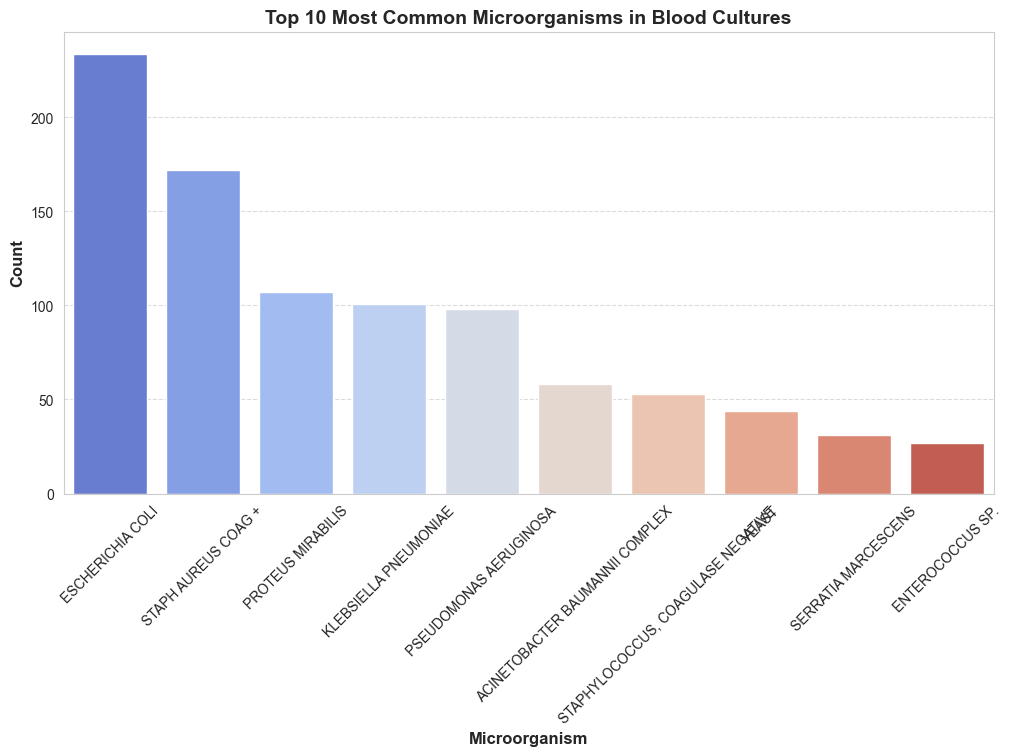

In [33]:

# 1. Most Common Microorganisms in Blood Cultures
top_microorganisms = microbio_df["org_name"].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_microorganisms.index, y=top_microorganisms.values, palette="coolwarm")
plt.xlabel("Microorganism", fontsize=12, weight="bold")
plt.ylabel("Count", fontsize=12, weight="bold")
plt.title("Top 10 Most Common Microorganisms in Blood Cultures", fontsize=14, weight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## #2 Trend of Prescriptions Over Time

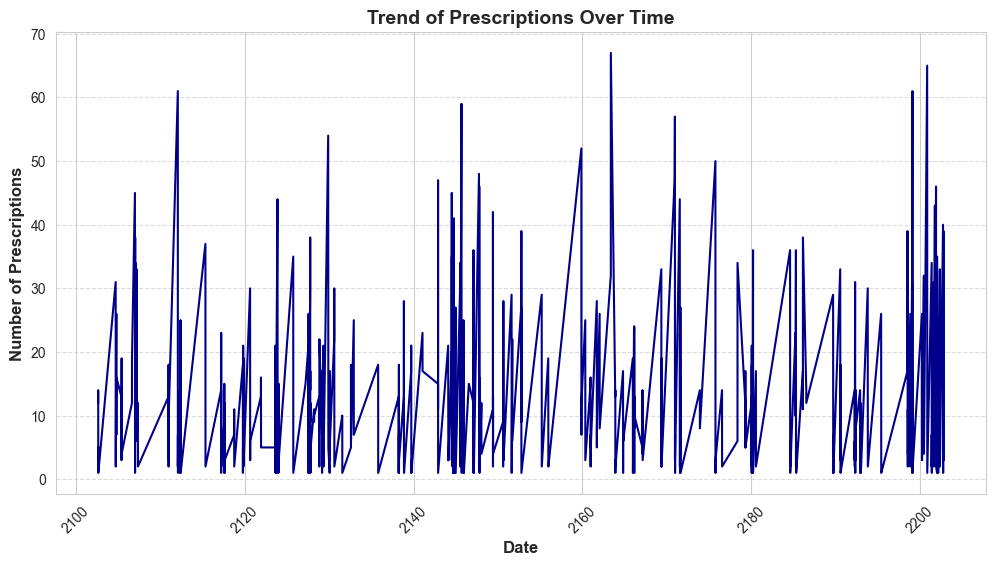

In [34]:

# 2. Trend of Prescriptions Over Time
prescriptions_df["startdate"] = pd.to_datetime(prescriptions_df["startdate"], errors="coerce")
prescription_trend = prescriptions_df.groupby(prescriptions_df["startdate"].dt.date).size()

plt.figure(figsize=(12, 6))
sns.lineplot(x=prescription_trend.index, y=prescription_trend.values, color="darkblue")
plt.xlabel("Date", fontsize=12, weight="bold")
plt.ylabel("Number of Prescriptions", fontsize=12, weight="bold")
plt.title("Trend of Prescriptions Over Time", fontsize=14, weight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## #3 Top 10 Prescribed Drugs

/var/folders/29/8ncbdz4n013f2p__f12f36qr0000gn/T/ipykernel_4981/1434137606.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




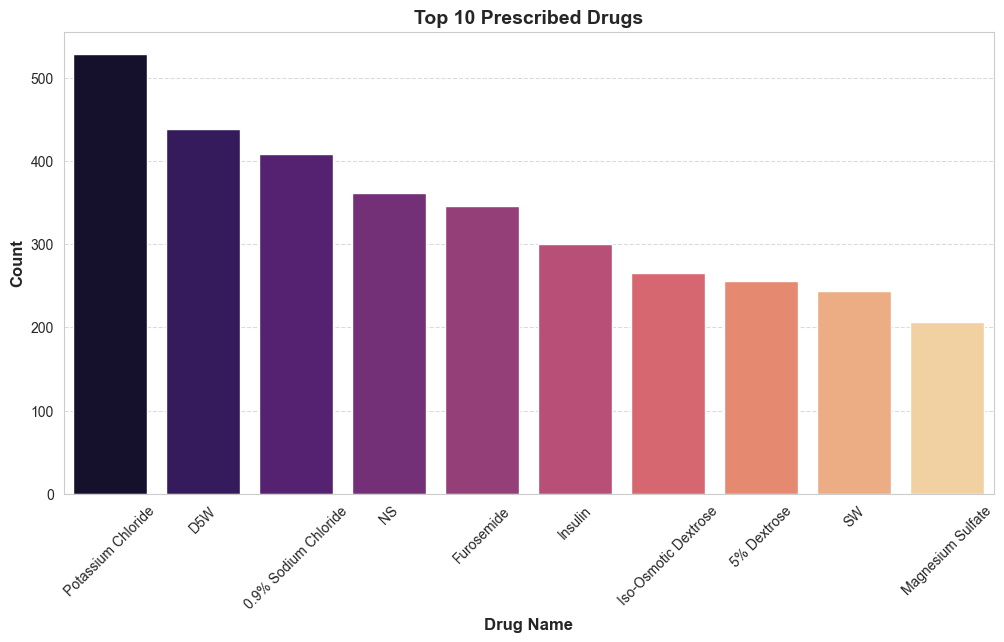

In [35]:

# 3. Top 10 Prescribed Drugs
top_drugs = prescriptions_df["drug"].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs.index, y=top_drugs.values, palette="magma")
plt.xlabel("Drug Name", fontsize=12, weight="bold")
plt.ylabel("Count", fontsize=12, weight="bold")
plt.title("Top 10 Prescribed Drugs", fontsize=14, weight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## #4 Antibiotic Resistance Pattern

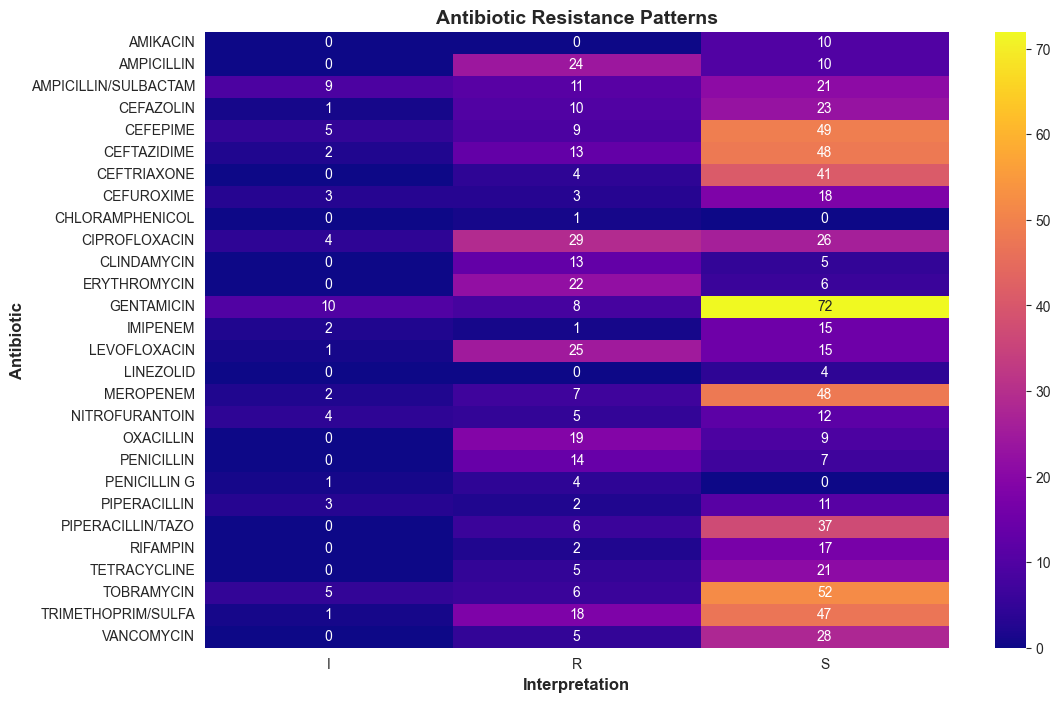

In [36]:

# 4. Antibiotic Resistance Patterns (Heatmap)
antibiotic_data = microbio_df.dropna(subset=["ab_name", "interpretation"])
pivot_table = antibiotic_data.pivot_table(index="ab_name", columns="interpretation", aggfunc="size", fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="plasma", fmt="d")
plt.xlabel("Interpretation", fontsize=12, weight="bold")
plt.ylabel("Antibiotic", fontsize=12, weight="bold")
plt.title("Antibiotic Resistance Patterns", fontsize=14, weight="bold")
plt.show()


## #5 Diagnosis-Based Prescription

In [ ]:
# 5. Diagnosis-Based Prescription Network Graph

import pandas as pd
import networkx as nx
import plotly.graph_objects as go

# Load the datasets (replace with actual paths if needed)
df_diagnoses_desc = pd.read_csv("D_ICD_DIAGNOSES.csv")
df_diagnoses = pd.read_csv("DIAGNOSES_ICD.csv")
df_prescriptions = pd.read_csv("PRESCRIPTIONS.csv")

# Merge diagnoses with descriptions
df_diagnoses = df_diagnoses.merge(df_diagnoses_desc[['icd9_code', 'short_title']], on='icd9_code', how='left')

# Merge diagnoses with prescriptions based on hadm_id (hospital admission ID)
df_merged = df_diagnoses.merge(df_prescriptions[['hadm_id', 'drug']], on='hadm_id', how='inner')

# Count occurrences of each diagnosis-prescription pair
top_pairs = df_merged.groupby(['short_title', 'drug']).size().reset_index(name='count')

# Select the top 100 most common pairs
top_pairs = top_pairs.nlargest(100, 'count')

# Create a new graph with only the top 20 pairs
G_top = nx.Graph()

for _, row in top_pairs.iterrows():
    G_top.add_node(row['short_title'], type='diagnosis')
    G_top.add_node(row['drug'], type='drug')
    G_top.add_edge(row['short_title'], row['drug'], weight=row['count'])

# Position nodes using spring layout
pos_top = nx.spring_layout(G_top, seed=42)

# Create edge traces
edge_x_top = []
edge_y_top = []

for edge in G_top.edges():
    x0, y0 = pos_top[edge[0]]
    x1, y1 = pos_top[edge[1]]
    edge_x_top.extend([x0, x1, None])
    edge_y_top.extend([y0, y1, None])

edge_trace_top = go.Scatter(
    x=edge_x_top, y=edge_y_top,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create node traces
node_x_top = []
node_y_top = []
node_text_top = []
node_color_top = []

for node in G_top.nodes():
    x, y = pos_top[node]
    node_x_top.append(x)
    node_y_top.append(y)
    node_text_top.append(node)
    node_color_top.append('blue' if G_top.nodes[node]['type'] == 'diagnosis' else 'red')

node_trace_top = go.Scatter(
    x=node_x_top, y=node_y_top,
    mode='markers',
    hoverinfo='text',
    text=node_text_top,
    marker=dict(
        showscale=True,
        colorscale='Bluered',
        size=10,
        color=node_color_top,
        line_width=2
    )
)

# Create figure
fig_top = go.Figure(data=[edge_trace_top, node_trace_top],
                    layout=go.Layout(
                        title="Top 100 Prescription-Diagnosis Network Graph",
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

# Show the interactive graph
import plotly.io as pio
pio.show(fig_top)
